<a href="https://colab.research.google.com/github/ssabrut/knee-arthritis-detection/blob/main/Annotated_Dataset_for_Knee_Arthritis_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import files

# # upload your kaggle.json API
# uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle datasets download -d hafiznouman786/annotated-dataset-for-knee-arthritis-detection

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/annotated-dataset-for-knee-arthritis-detection
License(s): CC0-1.0
 96% 56.0M/58.3M [00:05<00:00, 17.0MB/s]
100% 58.3M/58.3M [00:05<00:00, 11.6MB/s]


In [4]:
# !unzip annotated-dataset-for-knee-arthritis-detection.zip

Archive:  annotated-dataset-for-knee-arthritis-detection.zip
  inflating: Training/0Normal/NormalG0 (1).png  
  inflating: Training/0Normal/NormalG0 (10).png  
  inflating: Training/0Normal/NormalG0 (100).png  
  inflating: Training/0Normal/NormalG0 (101).png  
  inflating: Training/0Normal/NormalG0 (102).png  
  inflating: Training/0Normal/NormalG0 (103).png  
  inflating: Training/0Normal/NormalG0 (104).png  
  inflating: Training/0Normal/NormalG0 (105).png  
  inflating: Training/0Normal/NormalG0 (106).png  
  inflating: Training/0Normal/NormalG0 (107).png  
  inflating: Training/0Normal/NormalG0 (108).png  
  inflating: Training/0Normal/NormalG0 (109).png  
  inflating: Training/0Normal/NormalG0 (11).png  
  inflating: Training/0Normal/NormalG0 (110).png  
  inflating: Training/0Normal/NormalG0 (111).png  
  inflating: Training/0Normal/NormalG0 (112).png  
  inflating: Training/0Normal/NormalG0 (113).png  
  inflating: Training/0Normal/NormalG0 (114).png  
  inflating: Training/0No

In [47]:
from PIL import Image

width, height = Image.open('/content/Training/0Normal/NormalG0 (1).png').size
print('Image width:', width)
print('Image height:', height)

Image width: 300
Image height: 162


In [6]:
from tensorflow import keras

images = keras.utils.image_dataset_from_directory('Training', image_size=(height, width))
class_names = images.class_names

Found 1650 files belonging to 5 classes.


In [7]:
def plot_images(generator):
  plt.figure(figsize=(18, 7))
  for image, labels in generator.take(1):
    for i in range(18):
      ax = plt.subplot(3, 6, i + 1)
      plt.imshow(image[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

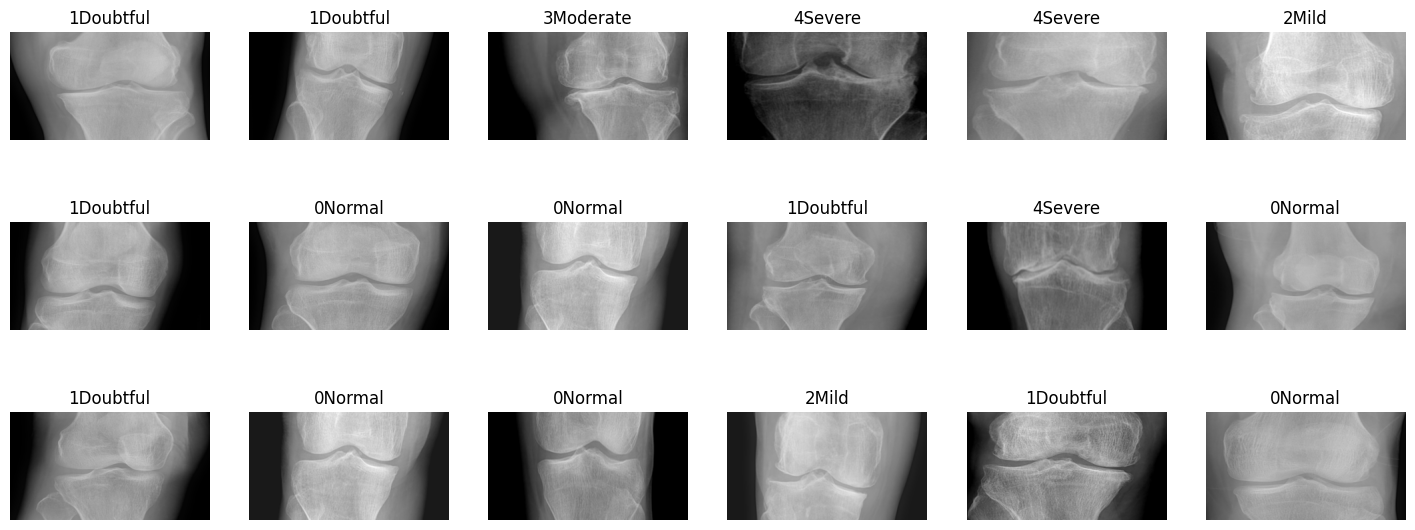

In [8]:
from matplotlib import pyplot as plt

# display random image from each class
plot_images(images)

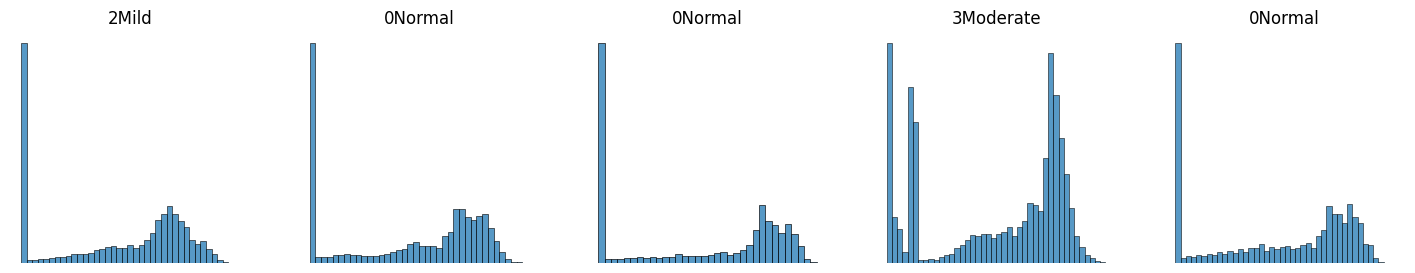

In [9]:
import seaborn as sns

# plot the histogram from each image to see the pixel distribution
plt.figure(figsize=(18, 3))
for image, labels in images.take(1):
  for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    flat_image = image[i].numpy().flatten().astype("uint8")
    sns.histplot(flat_image, ax=ax)
    ax.set_title(class_names[labels[i]])
    ax.axis("off")
plt.show()

# Image Processing

## Histogram Equalization

In [10]:
!pip install --upgrade keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 64.7 MB/s eta 0:00:00


In [11]:
import keras_cv

he = keras_cv.layers.Equalization((0,255))
he_images = images.map(lambda x, y: (he(x), y))

Using TensorFlow backend


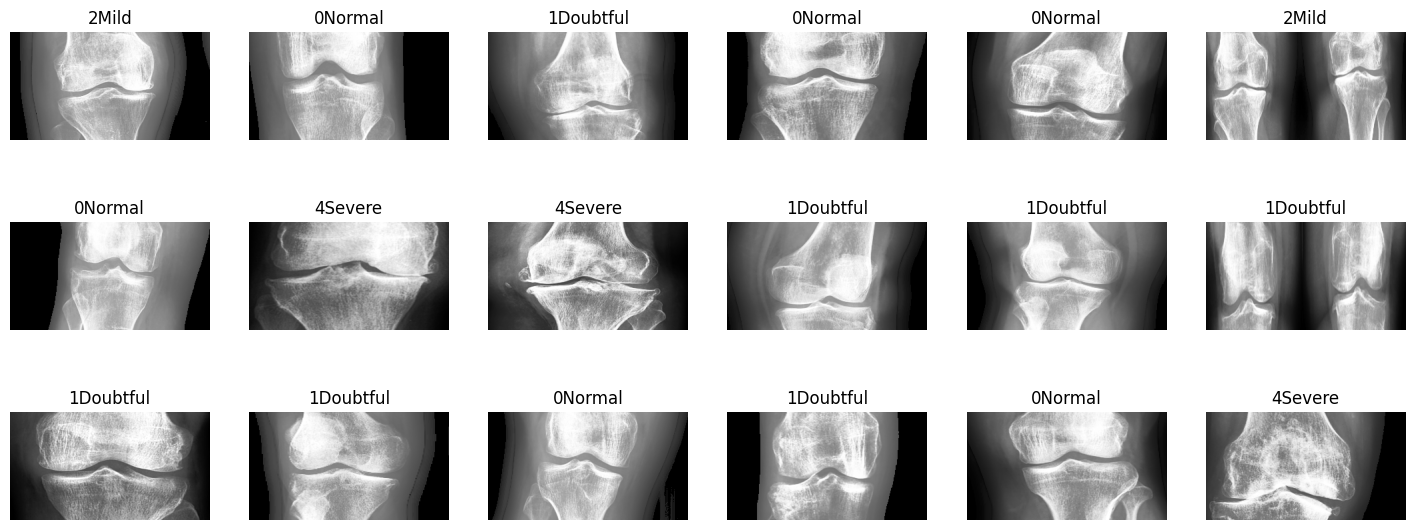

In [12]:
plot_images(he_images)

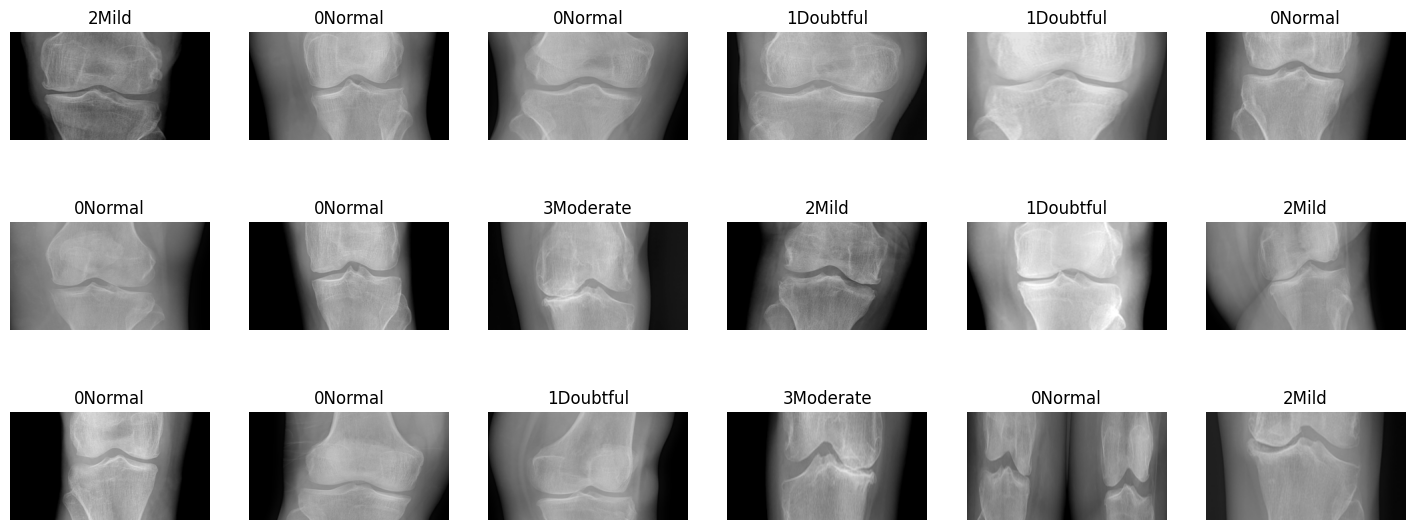

In [13]:
plot_images(images)

## Gamma Correction

In [14]:
from tensorflow import image

gamma_correction_images = images.map(lambda x, y: (image.adjust_gamma(x, .9), y))

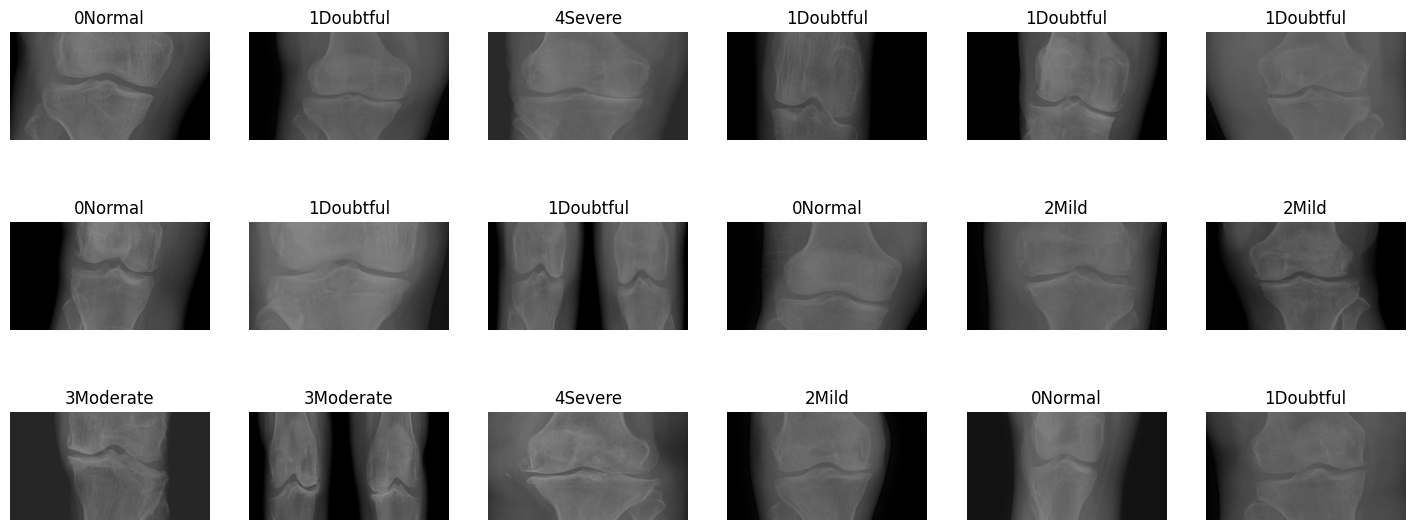

In [15]:
plot_images(gamma_correction_images)

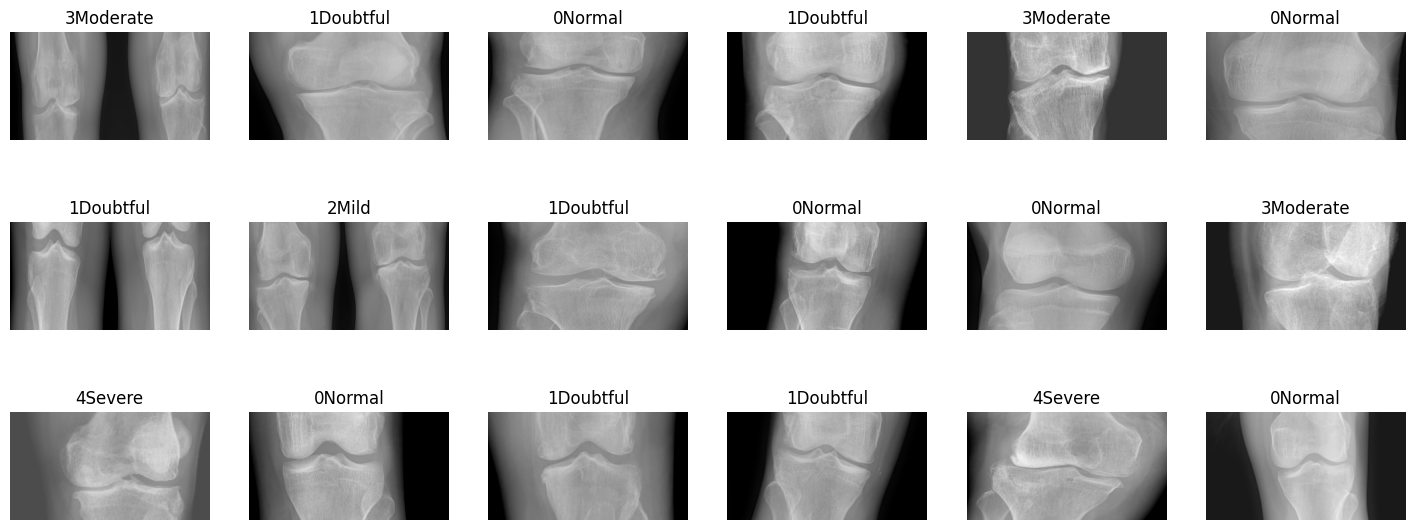

In [16]:
plot_images(images)

# Augmentation

In [17]:
from keras import layers

normalization_layer = layers.Rescaling(1./255)

In [18]:
normalized_images = images.map(lambda x, y: (normalization_layer(x), y))
normalized_he_images = he_images.map(lambda x, y: (normalization_layer(x), y))
normalized_gamma_correction_images = gamma_correction_images.map(lambda x, y: (normalization_layer(x), y))

In [19]:
import numpy as np

image_batch, labels_batch = next(iter(normalized_images))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.03529412 0.9803922


In [20]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

normalized_images = normalized_images.cache().prefetch(buffer_size=AUTOTUNE)
normalized_he_images = normalized_he_images.cache().prefetch(buffer_size=AUTOTUNE)
normalized_gamma_correction_images = normalized_gamma_correction_images.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
train_portion = .7
val_portion = .2
test_portion = .1

In [39]:
train_length = int(train_portion * 1650)
val_length = int(val_portion * 1650)
test_length = int(test_portion * 1650)

# Data Splitting

In [43]:
train_normalized_images = normalized_images.take(train_length)
val_normalized_images = normalized_images.skip(train_length).take(val_length)
test_normalized_images = normalized_images.skip(train_length + val_length).take(test_length)

In [44]:
train_normalized_he_images = normalized_he_images.take(train_length)
val_normalized_he_images = normalized_he_images.skip(train_length).take(val_length)
test_normalized_he_images = normalized_he_images.skip(train_length + val_length).take(test_length)

In [45]:
train_normalized_gamma_correction_images = normalized_gamma_correction_images.take(train_length)
val_normalized_gamma_correction_images = normalized_gamma_correction_images.skip(train_length).take(val_length)
test_normalized_gamma_correction_images = normalized_gamma_correction_images.skip(train_length + val_length).take(test_length)

# Configure hyperparameter

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 144
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

# Modeling

In [49]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=keras.activations.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x